In [ ]:
!pip install pyspark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import from_unixtime
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL shows") \
    .getOrCreate()

**Collecting data**

In [2]:
df = spark.read.json("feeds_show.json")
df.createOrReplaceTempView("shows")

**1. Data structure**



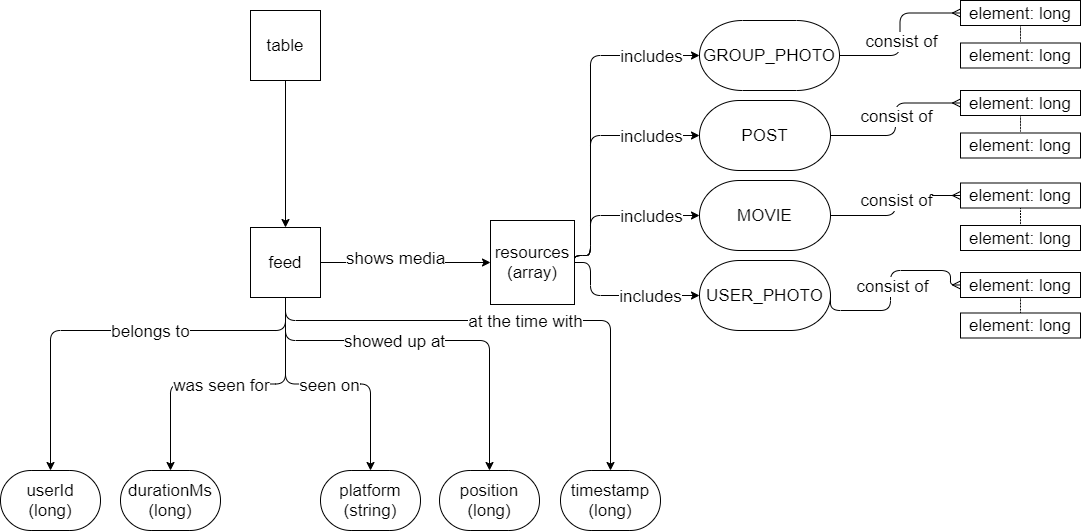

In [3]:
df.printSchema()

root
 |-- durationMs: long (nullable = true)
 |-- owners: struct (nullable = true)
 |    |-- group: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- user: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |-- platform: string (nullable = true)
 |-- position: long (nullable = true)
 |-- resources: struct (nullable = true)
 |    |-- GROUP_PHOTO: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- MOVIE: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- POST: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- USER_PHOTO: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |-- timestamp: long (nullable = true)
 |-- userId: long (nullable = true)



In [89]:
df.sample(0.05).show()

+----------+---------------+-----------+--------+--------------------+-------------+------+
|durationMs|         owners|   platform|position|           resources|    timestamp|userId|
+----------+---------------+-----------+--------+--------------------+-------------+------+
|      3732|{[47480], null}|APP_ANDROID|       7|{[13677], null, [...|1568296060000|  9058|
|      2013|{[55199], null}|DESKTOP_WEB|     248|{[49831, 6529, 80...|1568309587531| 45484|
|     10002|{null, [42086]}| MOBILE_WEB|      22|{null, null, null...|1568313211000| 48050|
|      2362|   {null, null}|DESKTOP_WEB|       8|{null, null, null...|1568301868110| 51770|
|       312|   {null, null}|DESKTOP_WEB|      38|{null, null, null...|1568260084519|  8812|
|      1030|   {null, null}|DESKTOP_WEB|     582|{null, null, null...|1568305290524| 18371|
|      1510|{[34222], null}|APP_ANDROID|      82|{[42893], null, [...|1568282434000| 39935|
|      2657|{null, [46445]}|APP_ANDROID|       2|{null, null, null...|1568310788

**Converting to date**

Convert TIMESTAMP to DATETIME for more convenient partitioning by date

In [6]:
dated_df = df.select('*', from_unixtime(F.col('timestamp') / 1000, format="yyyy-MM-dd").alias('show_date'))
dated_df.createOrReplaceTempView("d_shows")
dated_df.show()

+----------+---------------+-----------+--------+--------------------+-------------+------+----------+
|durationMs|         owners|   platform|position|           resources|    timestamp|userId| show_date|
+----------+---------------+-----------+--------+--------------------+-------------+------+----------+
|      1150|   {null, null}|APP_ANDROID|       4|{null, null, null...|1568317626000| 37686|2019-09-12|
|      3717|{[21055], null}|APP_ANDROID|     155|{null, [44250], [...|1568300551000| 21783|2019-09-12|
|      4208|{null, [50893]}|APP_ANDROID|      42|{null, null, null...|1568310811000| 50581|2019-09-12|
|      1787|   {null, null}|DESKTOP_WEB|      41|{null, null, null...|1568314907726| 27444|2019-09-12|
|      1254|   {null, null}|APP_ANDROID|      34|{null, null, null...|1568291064000| 56550|2019-09-12|
|      3331| {null, [3805]}|APP_ANDROID|      55|{null, null, [455...|1568266060000| 39935|2019-09-12|
|      8143|{[45075], null}|APP_ANDROID|      40|{[4724], null, [1...|156

**2. Tests**

In [267]:
spark.sql('SELECT * FROM d_shows WHERE durationMs IS NULL').show() # expected: empty table

+----------+---------------+------------+--------+--------------------+-------------+------+----------+
|durationMs|         owners|    platform|position|           resources|    timestamp|userId| show_date|
+----------+---------------+------------+--------+--------------------+-------------+------+----------+
|      null|{null, [12584]}| APP_ANDROID|     387|{null, null, [378...|1568319932000| 37401|2019-09-12|
|      null|   {null, null}| APP_ANDROID|      88|{null, null, null...|1568308319000|  4795|2019-09-12|
|      null|{null, [12933]}| APP_ANDROID|      25|{null, [54010], [...|1568257722000| 37401|2019-09-12|
|      null|{null, [57094]}| APP_ANDROID|      37|{null, null, null...|1568257764000| 37401|2019-09-12|
|      null|{[56161], null}| APP_ANDROID|     310|{null, [29708], [...|1568319891000| 37401|2019-09-12|
|      null|   {null, null}| APP_ANDROID|      57|{null, null, null...|1568319602000| 37401|2019-09-12|
|      null|   {null, null}| APP_ANDROID|      30|{null, null, n

In [268]:
spark.sql('SELECT * FROM d_shows WHERE position IS NULL').show() # expected: empty table

+----------+---------------+-----------+--------+--------------------+-------------+------+----------+
|durationMs|         owners|   platform|position|           resources|    timestamp|userId| show_date|
+----------+---------------+-----------+--------+--------------------+-------------+------+----------+
|     10000|{null, [51719]}|DESKTOP_WEB|    null|{null, null, null...|1568293615986| 54581|2019-09-12|
|       926|   {null, null}|    APP_IOS|    null|{null, null, null...|1568257315000| 39866|2019-09-12|
|      1178|   {null, null}|DESKTOP_WEB|    null|{null, null, null...|1568307826648|  2499|2019-09-12|
|      1790|   {null, null}|DESKTOP_WEB|    null|{null, null, null...|1568287701318| 53335|2019-09-12|
|     10000|   {null, null}|DESKTOP_WEB|    null|{null, null, null...|1568297057802| 53915|2019-09-12|
|      3219|   {null, null}|APP_ANDROID|    null|{null, null, null...|1568281855000|   434|2019-09-12|
|     10000|   {null, null}|DESKTOP_WEB|    null|{null, null, null...|156

In [270]:
spark.sql('SELECT * FROM d_shows WHERE userId IS NULL').show() # expected: empty table

+----------+------+--------+--------+---------+---------+------+---------+
|durationMs|owners|platform|position|resources|timestamp|userId|show_date|
+----------+------+--------+--------+---------+---------+------+---------+
+----------+------+--------+--------+---------+---------+------+---------+



In [273]:
spark.sql('SELECT * FROM d_shows WHERE (owners.group IS NULL AND owners.user IS NULL)').show() # expected: empty table

+----------+------------+-----------+--------+--------------------+-------------+------+----------+
|durationMs|      owners|   platform|position|           resources|    timestamp|userId| show_date|
+----------+------------+-----------+--------+--------------------+-------------+------+----------+
|      1150|{null, null}|APP_ANDROID|       4|{null, null, null...|1568317626000| 37686|2019-09-12|
|      1787|{null, null}|DESKTOP_WEB|      41|{null, null, null...|1568314907726| 27444|2019-09-12|
|      1254|{null, null}|APP_ANDROID|      34|{null, null, null...|1568291064000| 56550|2019-09-12|
|     45960|{null, null}|APP_ANDROID|      31|{null, null, null...|1568314246000| 50581|2019-09-12|
|       307|{null, null}|DESKTOP_WEB|      41|{null, [20851, 46...|1568260085193|  8812|2019-09-12|
|      1307|{null, null}| MOBILE_WEB|      16|{null, null, null...|1568270315000| 16782|2019-09-12|
|      1035|{null, null}|APP_ANDROID|      12|{null, null, null...|1568273782000| 40546|2019-09-12|


In [275]:
dated_df.count() - dated_df.drop_duplicates().count() # expected: 0 

53

**3.a Amount of feeds a day on each platform**

In [279]:
dated_df.groupBy(dated_df['platform']).count().union(spark.sql('SELECT "SUMMARY", COUNT(*) FROM d_shows')).show()

+------------+-----+
|    platform|count|
+------------+-----+
|  MOBILE_WEB| 1378|
| APP_ANDROID|19871|
|     APP_IOS| 2470|
| DESKTOP_WEB|10352|
|APP_WINPHONE|  247|
|     SUMMARY|34318|
+------------+-----+



Complexity: Depends on query plan

**3.a Amount of unique users a day**

In [145]:
spark.sql('SELECT DISTINCT userId FROM d_shows WHERE platform = "MOBILE_WEB"').count()

16

In [146]:
spark.sql('SELECT DISTINCT userId FROM d_shows WHERE platform = "APP_ANDROID"').count()

114

In [148]:
spark.sql('SELECT DISTINCT userId FROM d_shows WHERE platform = "APP_IOS"').count()

26

In [147]:
spark.sql('SELECT DISTINCT userId FROM d_shows WHERE platform = "DESKTOP_WEB"').count()

55

In [149]:
spark.sql('SELECT DISTINCT userId FROM d_shows WHERE platform = "APP_WINPHONE"').count()

1

In [277]:
spark.sql('SELECT DISTINCT userId FROM d_shows WHERE NOT (platform IS NULL)').count()

200

**3.a Amount of unique users a day (Single query)**

In [19]:
spark.sql('SELECT DISTINCT platform, amount \
                         FROM (SELECT DISTINCT userId, platform, \
                         COUNT(*) OVER(PARTITION BY platform) AS amount \
                         FROM d_shows \
                         GROUP BY platform, userId) ').union(spark.sql(
                        'SELECT  "SUMMARY", \
                         COUNT(DISTINCT userId) FROM d_shows')).show()

+------------+------+
|    platform|amount|
+------------+------+
|  MOBILE_WEB|    16|
| APP_ANDROID|   114|
|     APP_IOS|    26|
| DESKTOP_WEB|    55|
|APP_WINPHONE|     1|
|     SUMMARY|   200|
+------------+------+



**3.b Unique authors**

author == user | group

In [260]:
spark.sql('SELECT "unique_authors", \
           COUNT(DISTINCT owners)  AS amount \
           FROM d_shows \
           WHERE (NOT owners.user IS NULL OR NOT owners.group IS NULL)').show()

+--------------+------+
|unique_authors|amount|
+--------------+------+
|unique_authors| 11218|
+--------------+------+



In [253]:
'''spark.sql('SELECT "author", COUNT(DISTINCT owners) AS AMOUNT \
           FROM d_shows \
           GROUP BY (NOT owners.group IS NULL AND owners.user IS NULL, \
           owners.group IS NULL AND owners.user IS NULL)').show()
           '''


+------+------+
|author|AMOUNT|
+------+------+
|author|  1703|
|author|  9515|
|author|     1|
+------+------+



**3.b Unique content**

In [265]:
spark.sql('SELECT "unique_content", COUNT(DISTINCT resources) AS amount FROM d_shows WHERE NOT resources IS NULL').show()

+--------------+------+
|unique_content|amount|
+--------------+------+
|unique_content| 20684|
+--------------+------+



**3.c Amount of sessions**

session = userId(*durationMs)  - entire duration on each userId a day 

Session of each user a day 

In [241]:
new_df = spark.sql('SELECT DISTINCT userId, \
          SUM(durationMs) OVER(PARTITION BY userId) AS session_time, \
          AVG(position) OVER(PARTITION BY userId) AS avg_position \
          FROM d_shows')
new_df.createOrReplaceTempView('user_metrics')
new_df.show()

+------+------------+------------------+
|userId|session_time|      avg_position|
+------+------------+------------------+
| 33862|     2284609| 58.17891373801917|
| 18598|        2645|              null|
| 36577|       98605|              4.25|
| 29507|      229933| 5.285714285714286|
| 35216|     1206127|51.129533678756474|
|  3869|     1260359| 66.34202898550724|
|  7540|   109181246|14.026315789473685|
| 21293|     5825902|377.62985074626863|
| 41801|       10000|              null|
| 44220|      398594| 9.818181818181818|
| 37105|      733676|               2.2|
|  7759|    15201817| 25.64264264264264|
| 39836|      285442| 8.117647058823529|
| 46718|       10000|              null|
|  3092|       82106|               5.5|
|  3689|    43030533|25.707070707070706|
| 13412|      202795| 24.88888888888889|
| 33287|        7778|              null|
|  7116|       14065|               1.0|
| 20116|      265664|  9.19047619047619|
+------+------------+------------------+
only showing top

Amount of sessions a day

In [200]:
spark.sql('SELECT COUNT(session_time) AS Amount FROM user_metrics').show()

+------+
|Amount|
+------+
|   198|
+------+



Average feed position a day

In [204]:
spark.sql('SELECT AVG(avg_position) AS Average_position FROM user_metrics').show()

+-----------------+
| Average_position|
+-----------------+
|37.11351769402006|
+-----------------+



Average session time a day

In [206]:
spark.sql('SELECT AVG(session_time) AS Average_session_time FROM user_metrics').show()

+--------------------+
|Average_session_time|
+--------------------+
|    4758256.51010101|
+--------------------+



**3.d Feeds per user a day**

In [274]:
spark.sql('SELECT DISTINCT userId, \
           COUNT(*) OVER (PARTITION BY userId) AS amount \
           FROM d_shows  \
           ORDER BY amount DESC').show()

+------+------+
|userId|amount|
+------+------+
|  7572|  1398|
| 18371|  1212|
| 51770|   995|
|  8812|   875|
| 39935|   871|
| 44407|   853|
| 56665|   769|
| 44552|   674|
| 52525|   669|
| 14597|   644|
| 50581|   606|
| 29726|   606|
| 37401|   578|
| 50802|   572|
|  4795|   565|
| 50302|   555|
|  9058|   552|
| 46047|   548|
| 51996|   531|
| 27444|   519|
+------+------+
only showing top 20 rows

